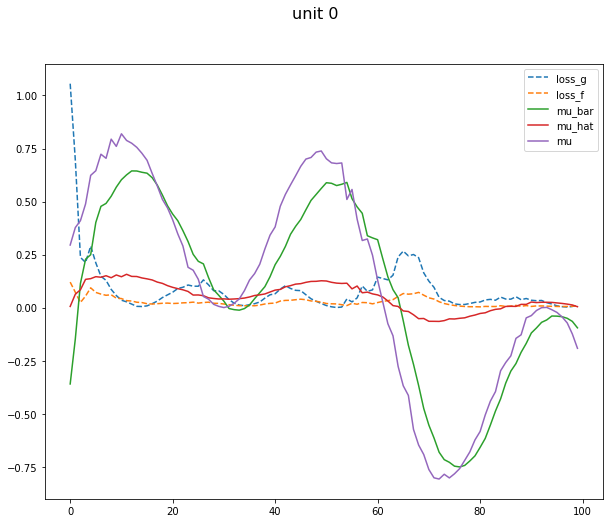

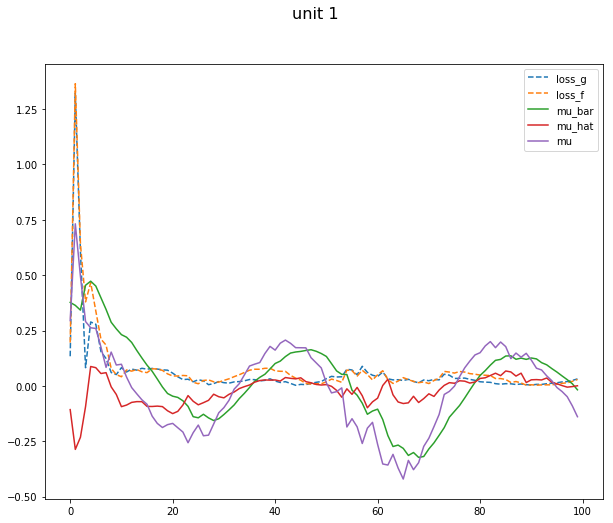

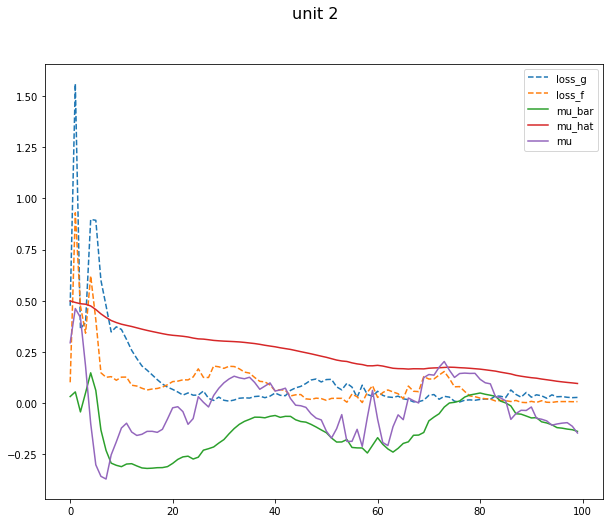

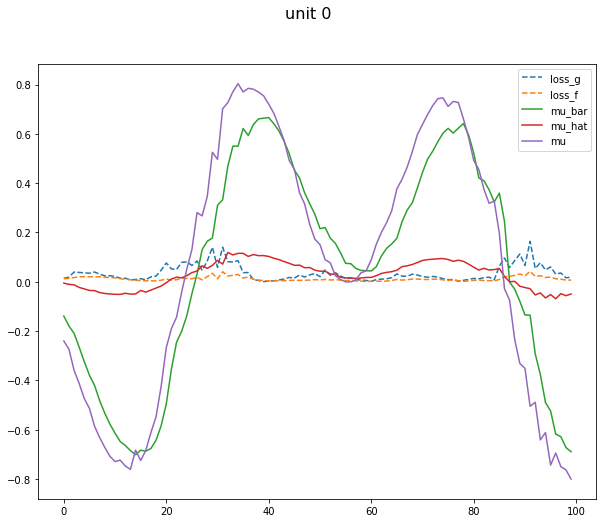

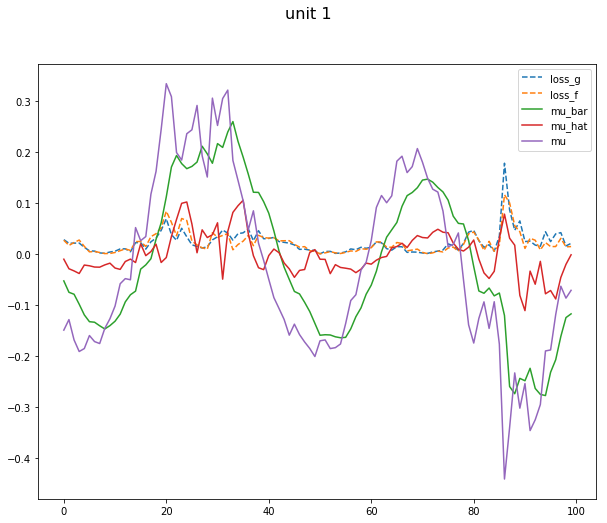

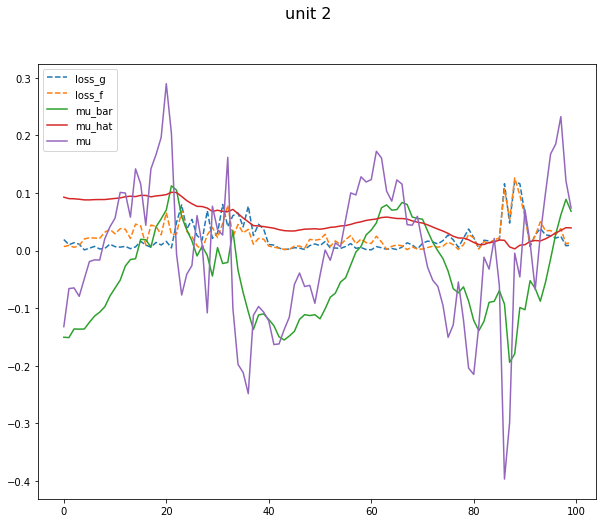

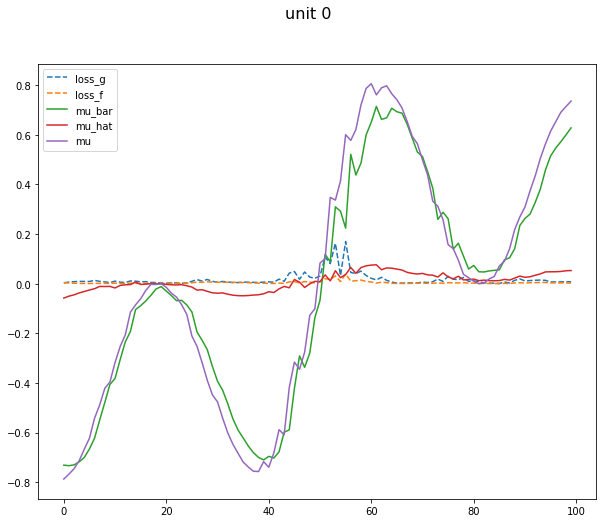

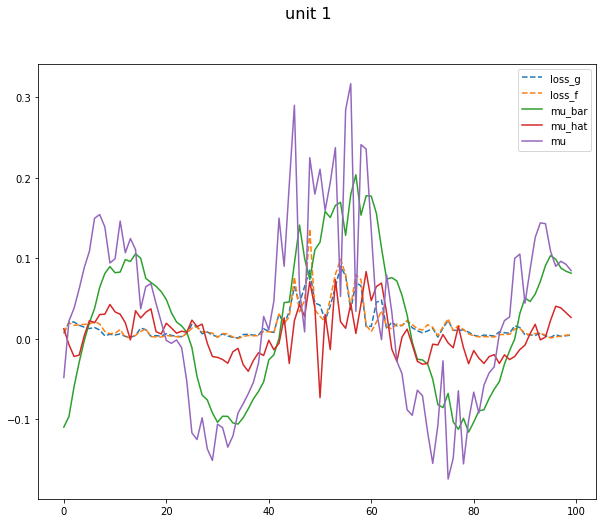

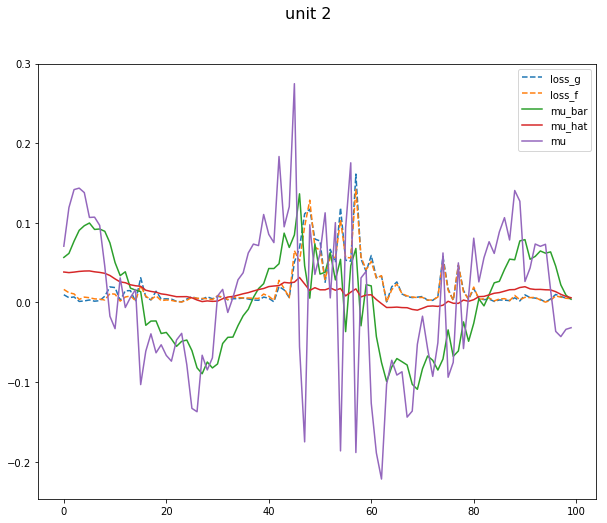

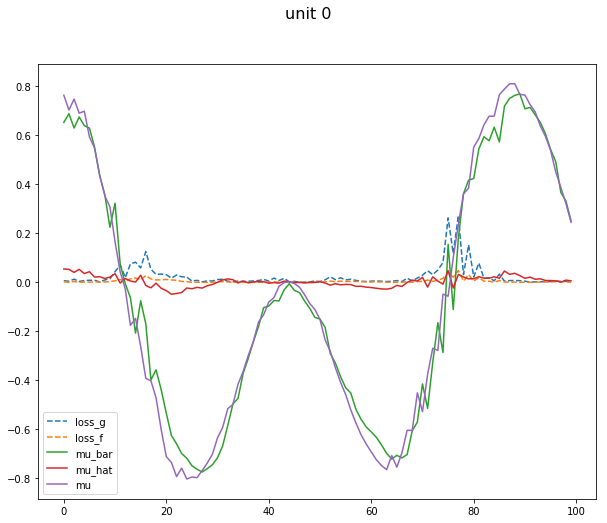

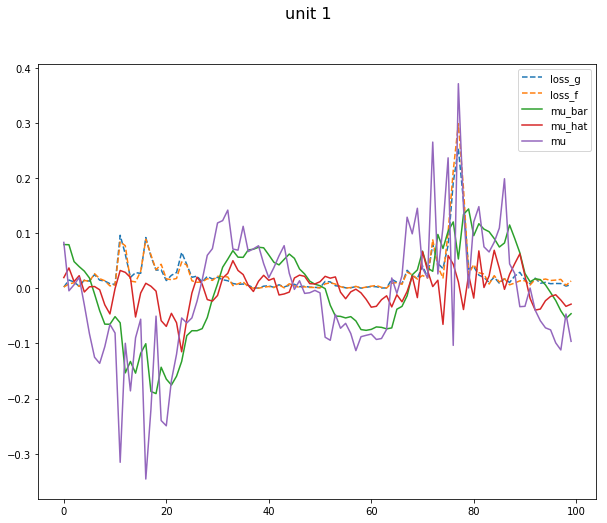

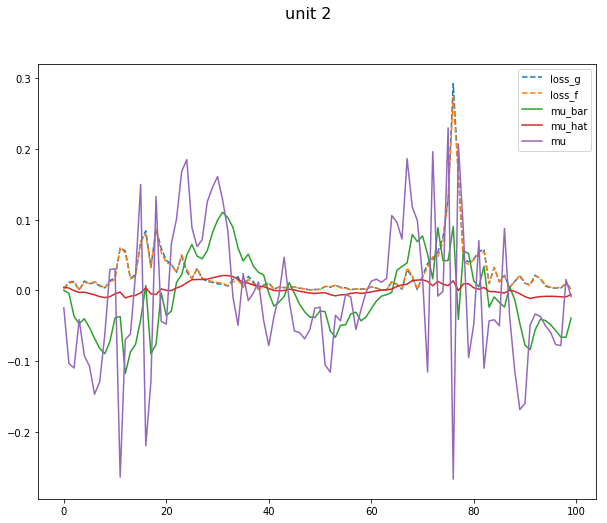

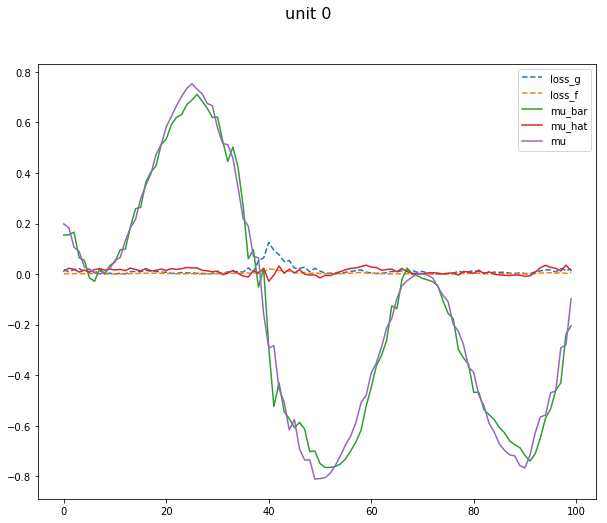

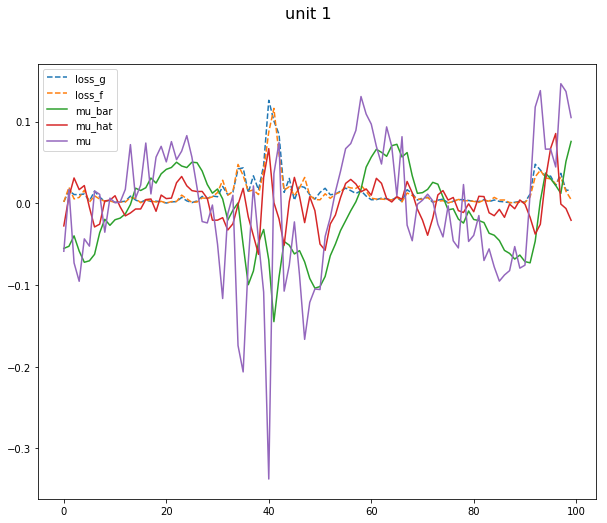

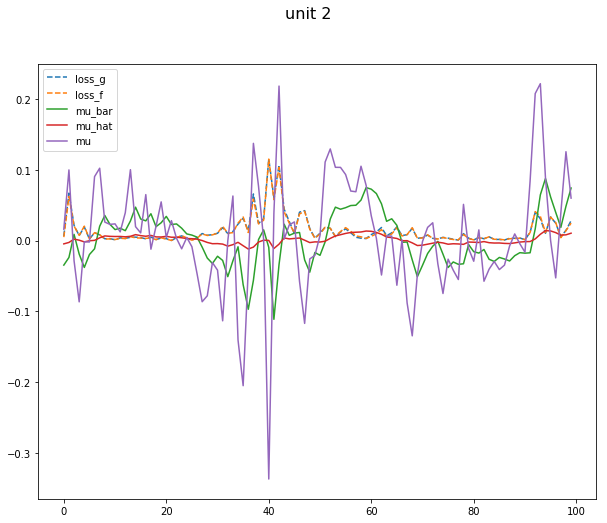

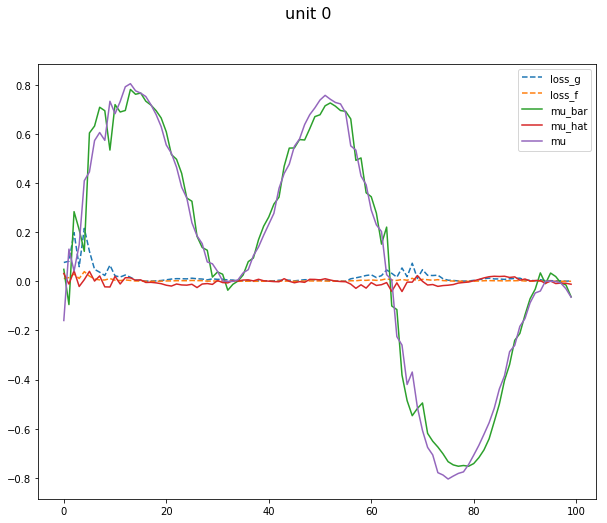

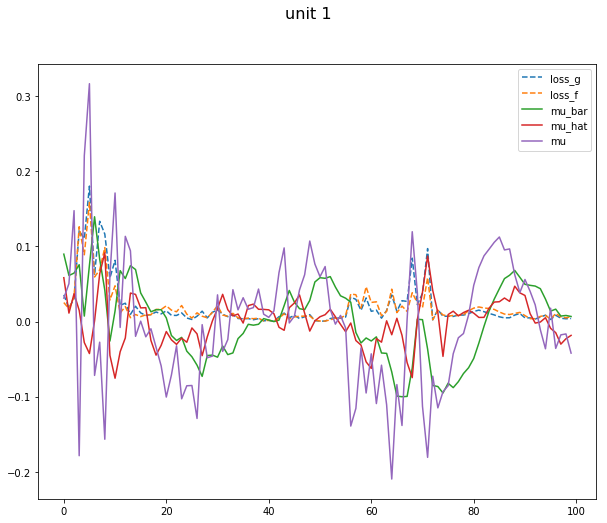

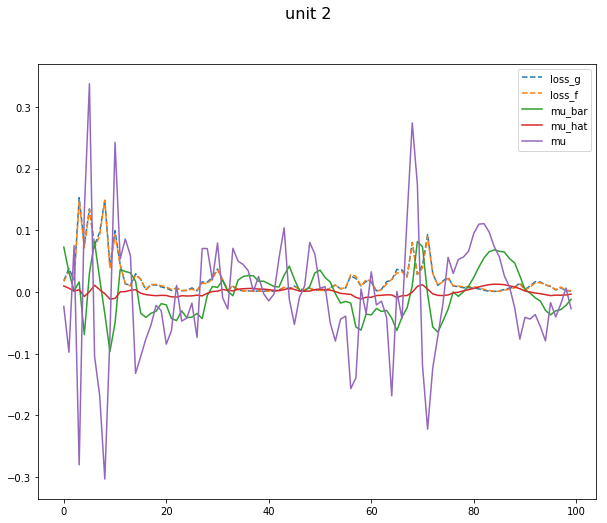

KeyboardInterrupt: 

In [6]:
from __future__ import print_function
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from torchviz import make_dot
import pdb

class G(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=10, t_sample=1):
        super(G, self).__init__()
        self.g1 = nn.Linear(input_size * t_sample, hidden_size)
        self.g2 = nn.Linear(hidden_size, output_size * t_sample)
        self.act = nn.Tanh()

    def forward(self, x):
        x = F.relu(self.g1(x))
        x = self.g2(x)
        x = self.act(x)
        return x
    
class Unit(nn.Module):
    def __init__(self, name, layer_index, mu_size, mu_next_size, t_sample, device):
        super(Unit, self).__init__()
        self.device = device
        self.name = name

        self.g = G(input_size=mu_next_size, output_size=mu_size, t_sample=t_sample)
        self.f = G(input_size=mu_size, output_size=mu_size, t_sample=t_sample)

        lr = 0.1
        self.optimizer_g = optim.SGD(self.g.parameters(), lr=(lr / 5.0)/(layer_index + 1), momentum=0)
        self.optimizer_f = optim.SGD(self.f.parameters(), lr=lr/(layer_index + 1), momentum=0)

        # this unit's state
        self.previous_mu = torch.zeros([mu_size * t_sample], requires_grad=True).to(device)
        self.mu = torch.zeros([mu_size * t_sample], requires_grad=True).to(device)
        self.mu_bar = torch.zeros([mu_size * t_sample], requires_grad=True).to(device)
        self.mu_hat = torch.zeros([mu_size * t_sample], requires_grad=True).to(device)

        # next unit's mu
        self.mu_next = torch.zeros([mu_next_size * t_sample], requires_grad=True).to(device)


    def before_step(self):
        self.g.train()
        self.f.train()

        self.optimizer_g.zero_grad()
        self.optimizer_f.zero_grad()

    def compute_predictions(self):
        self.mu_bar = self.f(self.previous_mu)
        self.mu_hat = self.g(self.mu_next)

    def train(self):
        loss_g = F.mse_loss(self.mu_hat, self.mu - self.mu_bar)
        loss_g.backward(retain_graph=True)
        self.optimizer_g.step()

        loss_f = F.mse_loss(self.mu_bar, self.mu)
        loss_f.backward(retain_graph=True)
        self.optimizer_f.step()

        self.previous_mu = self.mu

        return [loss_g, loss_f, self.mu_bar[-1], self.mu_hat[-1], self.mu[-1]]


class UnitStack(nn.Module):
    def __init__(self, units):
        super(UnitStack, self).__init__()
        self.units = units
        self.unit_count = len(units)

    def step(self, mu, mu_awareness):
        # before step initialization
        [self.units[layer].before_step() for layer in range(self.unit_count)]
        
        # forward error propagation
        self.units[0].mu = mu
        self.units[-1].mu_next = mu_awareness

        for layer in range(1, self.unit_count):
            # compute mu using previous layer's predictions
            # mu is part of the signal the previous layer could not predict
            self.units[layer].mu = self.units[layer - 1].mu - (self.units[layer - 1].mu_hat + self.units[layer - 1].mu_bar)
            self.units[layer - 1].mu_next = self.units[layer].mu

        # backward flow of predictions
        [self.units[layer].compute_predictions() for layer in range(self.unit_count - 1, -1, -1)]

        # train
        return [self.units[layer].train() for layer in range(self.unit_count)]
        
class SlidingWindowBuffer(object):
    def __init__(self, item_count, item_shape=(1,)):
        self.item_shape = item_shape
        self.item_count = item_count
        self.buffer = np.zeros((item_count,)).tolist()
        
    def append_item(self, item):
        # return None while gathering initial items
        if len(self.buffer) < self.item_count - 1:
            self.buffer.append(item)
            return None
        
        # once enough items, convert to np.array
        elif len(self.buffer) == self.item_count - 1:
            self.buffer.append(item)
            self.buffer = np.array(self.buffer)
            
        else:
            self.buffer = np.roll(self.buffer, -1, axis=0)
            self.buffer[-1] = item
            
        return self.buffer

class SampleDataPointsGenerator(object):
    def __init__(self, shape=(1,)):
        self.index = 0
        self.count = np.empty(shape).size
        
    def __next__(self):
        self.index += 1
        if self.count == 1:
            return np.sin(self.index/10.0 + np.random.random_sample() * 0.2) * np.cos(self.index/20.0)
        elif self.count == 2:
            return [
                np.cos(self.index/10.0 + np.random.random_sample() * 0.2) * np.sin(self.index/5.0),
                np.sin(self.index/10.0 + np.random.random_sample() * 0.2) * np.cos(self.index/20.0)
            ]

def plot_history(loss_history, title=None):
    loss_history = np.array(loss_history)
    fig = plt.figure(figsize=(10,8))
    fig.suptitle(title, fontsize=16)
    plt.plot(loss_history[:, 0],"--",label='loss_g')
    plt.plot(loss_history[:, 1],"--",label='loss_f')
    plt.plot(loss_history[:, 2],"-",label='mu_bar')
    plt.plot(loss_history[:, 3],"-",label='mu_hat')
    plt.plot(loss_history[:, 4],"-",label='mu')

    plt.legend()
    plt.show()
    
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
torch.set_num_threads(12)

t_sample = 5
mu_size = 1

unit0 = Unit(name="unit0", layer_index=0, mu_size=mu_size, mu_next_size=mu_size, t_sample = t_sample, device=device)
unit1 = Unit(name="unit1", layer_index=1, mu_size=mu_size, mu_next_size=mu_size, t_sample = t_sample, device=device)
unit2 = Unit(name="unit2", layer_index=2, mu_size=mu_size, mu_next_size=mu_size, t_sample = t_sample, device=device)


network = UnitStack([unit0, unit1, unit2])

loss_history = []
mu_buffer = SlidingWindowBuffer(t_sample)
mu_awareness = np.ones((t_sample,))

mu_awareness = torch.tensor(mu_awareness, requires_grad=True).float().to(device)
data_generator = SampleDataPointsGenerator()

for i in range(2000):
    mu_buffer.append_item(next(data_generator))

    mu = torch.tensor(mu_buffer.buffer).float().to(device)
    loss = network.step(mu=mu, mu_awareness=mu_awareness)
    # print(loss)

    loss_history.append(loss)
        
    if (i+1) % 100 == 0:
        plot_history(np.array(loss_history)[:, 0, :], title='unit 0')
        plot_history(np.array(loss_history)[:, 1, :], title='unit 1')
        plot_history(np.array(loss_history)[:, 2, :], title='unit 2')

        loss_history = []

print("==================")

# for i in range(500):
#     pred_mu = loss[2] + loss[3]
#     mu_buffer.append_item(pred_mu)
#     mu_next_buffer.append_item(1.)

#     mu = torch.tensor(mu_buffer.buffer).float().to(device)
#     mu_next = torch.tensor(mu_next_buffer.buffer).float().to(device)
#     loss = unit.step(mu, mu_next, device)
#     if loss[0] is not None:
#         loss_history.append(loss)
        
#     if (i+1) % 100 == 0:
#         plot_history(loss_history)
#         loss_history = []

